In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [56]:
data = loadmat('./ex4data1.mat')
X = data['X']
y = data['y'].flatten() #flatten() 将多维转为一维数组

In [105]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
def plot_100_image(X):
    sample_index = np.random.choice(X.shape[0],100) #从 N（个样本）中，随机选出100个数字
    sample_images = X[sample_index,:]#选择其中随机的100行 (100,400)
    
    fig, ax_arraya = plt.subplots(nrows=10,ncols=10,sharex=True,sharey=True,figsize=(8,8))
    for row in range(10):
        for col in range(10):
            ax_arraya[row,col].matshow(sample_images[10*row + col].reshape(20,20), cmap = 'gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

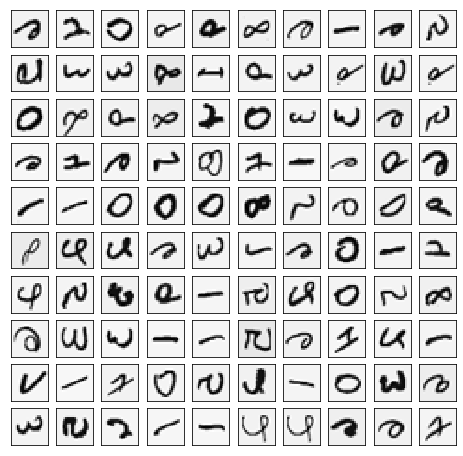

In [59]:
plot_100_image(X)

In [60]:
def expand_y(y): #oneHot编码y
    encoder = OneHotEncoder(sparse=False)
    oneHot_y = encoder.fit_transform(y.reshape(-1,1))
    return oneHot_y

In [61]:
#导入 预先训练好的THETA1 THETA2
def loadmat_Theta():
    data = loadmat('./ex4weights.mat')
    return data['Theta1'],data['Theta2']
T1,T2 = loadmat_Theta()
T1.shape,T2.shape

((25, 401), (10, 26))

In [62]:
def serialize(t1,t2):
    return np.r_[t1.flatten(),t2.flatten()] #(1, 25*401+10*26)

In [63]:
def deserialize(Theta):
    return Theta[:25*401].reshape(25,401), Theta[25*401:].reshape(10,26)

In [64]:
## Test:
# theta = serialize(T1,T2)
# deserialize(theta)

In [65]:
def segmoid(z):
    return 1/(1+np.exp(-z))

In [66]:
def feed_forward(Theta, X):
    Theta1,Theta2 = deserialize(Theta)

    # Theta1 (25,401)
    # Theta2 (10,26)
    # X (5000,401)
    a1 = X 
    assert a1.shape[1]==Theta1.T.shape[0],'erro a1:{}, Theta1:{}'.format(a1.shape,Theta1.shape)
    z2 = a1 @ Theta1.T
    a2 = segmoid(z2)
    a2 = np.append(np.ones((len(a2),1)),a2,axis=1)
    z3 = a2 @ Theta2.T
    a3 = segmoid(z3)
    return a1,z2,a2,z3,a3

In [67]:
Theta = serialize(T1,T2)
X_add_one = np.append(np.ones((len(X),1)),X,axis=1)

# feed_forward(Theta,X_add_one)

In [68]:
a1, z2, a2, z3, h = feed_forward(Theta, X_add_one)
a1.shape,z2.shape,a2.shape,z3.shape,h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

In [69]:
def cost(Theta, X, y):
    # y (5000, 10)
    # X (5000, 401)
    # Theta (1, 25*401+10*26)
    a1, z2, a2, z3, h = feed_forward(Theta, X)
    # h (5000, 10)
    J = -y * np.log(h) - (1-y) * np.log(1-h)
    return np.sum(J)/len(X)

In [70]:
cost(Theta, X_add_one, expand_y(y))
# excand_y(y).shape,h.shape

0.2876291651613189

In [71]:
def regularized_cost(Theta, X, y, l=1):
    t1,t2 =deserialize(Theta)
    reg = l/(2*len(X)) * (np.sum(np.power(t1[:,1:],2))+np.sum(np.power(t2[:,1:],2)))
    return reg+cost(Theta, X, y)

In [72]:
regularized_cost(Theta, X_add_one, expand_y(y))

0.38376985909092365

# 反向传播

In [73]:
def sigmoid_gradient(z):
    return segmoid(z)*(1-segmoid(z))

In [74]:
def random_init(size):
    return np.random.uniform(-0.12,0.12,size)

In [75]:
def backprop(Theta,X,y):
    # y 是已经经过oneHot (5000,10)
    
    # Theta1 (25,401)
    # Theta2 (10,26)
    Theta1,Theat2 = deserialize(Theta)
    a1,z2,a2,z3,h = feed_forward(Theta, X)
    #(a1(5000, 401), z2(5000, 25), a2(5000, 26), z3(5000, 10), h(5000, 10))
    d3 = h-y #(5000,10)
    d2 =d3 @ Theat2[:,1:]  * sigmoid_gradient(z2) #(5000,25)
    
    D2 = d3.T @ a2 #(10,26)
    D1 = d2.T @ a1  #(25,401)

    D = 1/(2*len(X)) * serialize(D1,D2)

    return D

In [76]:
backprop(Theta,X_add_one,expand_y(y)).shape, backprop(Theta,X_add_one,expand_y(y))

((10285,),
 array([ 3.09356383e-05,  0.00000000e+00,  0.00000000e+00, ...,
         4.83052360e-05, -3.78868423e-04,  3.86664936e-04]))

In [77]:
def gradient_checking(Theta, X, y, e):
    def gradApprox(theta_plus,theta_minus):
        return (regularized_cost(theta_plus,X,y) - regularized_cost(theta_minus,X,y))/(2*e)

    numeric_grad=[]
    for i in range(len(Theta)): #对每一个Theta进行梯度检测
        plus = Theta.copy()
        minus = Theta.copy()
        plus[i] = plus[i] + e
        minus[i] = plus[i] + e
        numeric_grad.append(gradApprox(plus,minus))  

    return numeric_grad

In [78]:
# gradient_checking(Theta, X_add_one, expand_y(y), 0.00001)

In [91]:
def regularized_gradient(Theta, X, y, l):
   # y 是已经经过oneHot (5000,10)
    
    # Theta1 (25,401)
    # Theta2 (10,26)
    Theta1,Theta2 = deserialize(Theta)
    a1,z2,a2,z3,h = feed_forward(Theta, X)
    #(a1(5000, 401), z2(5000, 25), a2(5000, 26), z3(5000, 10), h(5000, 10))
    D1,D2 = deserialize(backprop(Theta,X,y))
    Theta1[:,0] = 0
    Theta2[:,0] = 0
    reg_D1 = D1 + (1/len(X))*Theta1
    reg_D2 = D2 + (1/len(X))*Theta2

    return serialize(reg_D1,reg_D2)

In [92]:
def BP_trans(X, y):
    
    init_theta = random_init(25*401+10*26)

    res = minimize(fun=regularized_cost,x0=init_theta,method='tnc',jac=regularized_gradient,args=(X,y,1))
    return res

In [93]:
BP_trans(X_add_one,expand_y(y))

     fun: 0.35351535596676986
     jac: array([ 2.72927172e-04,  3.97386360e-07,  3.82633349e-07, ...,
       -9.56898024e-05, -2.85006185e-05,  3.49481129e-05])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 281
     nit: 22
  status: 1
 success: True
       x: array([ 1.03572647e+00,  1.98693180e-03,  1.91316674e-03, ...,
        1.46403503e+00, -3.00869642e+00, -1.21766696e+00])

In [109]:
def accuracy(theta, X, y):
    _, _, _, _, h = feed_forward(Theta, X)
    y_pred = np.argmax(h, axis=1) + 1
    return classification_report(y, y_pred)

In [111]:
print(accuracy(Theta, X_add_one, y))

precision    recall  f1-score   support

           1       0.97      0.98      0.98       500
           2       0.98      0.97      0.98       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.97      0.98      0.98       500
           6       0.98      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

